In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, normalize
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

In [3]:
# Model Display
from IPython.display import SVG
import pydot, pydotplus, graphviz
from keras.utils import model_to_dot

In [4]:
# Set filenames here
cfi = 'data/covid_cases.csv' # Case time series
dfi = 'data/covid_deaths.csv' # Death time series

In [6]:
# Load and shape data
casesdf = pd.read_csv(cfi).iloc[:,11:].apply(sum).values
deathdf = pd.read_csv(dfi).iloc[:,12:].apply(sum).values
casesdf = casesdf.reshape(len(casesdf), 1)
deathdf = deathdf.reshape(len(deathdf), 1)
#
# Import dataset, confirmed cases time series
origdf = pd.read_csv("data/confirmed_diff.csv")
df = origdf.copy()
df.dropna()
df = df[['region', 'Value', 'Province_State']]

In [37]:
# Getters
def get_dataset(dataset, n_steps=1, split=0.75, shuff=False):
    #print(dataset.shape)
    X, y = [], []
    for i in range(len(dataset) - n_steps - 1):
        a = dataset[i:(i+n_steps)]
        X.append(a)
        y.append(dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=(1-split), shuffle=shuff)

def organize_data(x, days_offset=10):
    # Unused
    x['id'] = range(len(x)) 
    # Standardize x-value
    x['norm-0'] = (x['Value'] - x['Value'].mean()) / x['Value'].std()
    # Create columns for past days
    for item in range(days_offset):
        x['norm-%s'%str(item+1)] = x.shift(periods=(1+item))['norm-0']
    # And truncate the NAs
    out = x[days_offset:]
    return out

def get_ynn(train_dataset):
    # 2 hidden layers, 128 units, activation functions specified as relu
    # and 1 final layer for prediction result
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

def get_cnn(n_steps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, 
                     activation='relu', 
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

def get_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

def get_stacked_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

def evaluate_model(mname, history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{mname} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_test(mname, y, y_hat):
    plt.plot(y, 'bo-', label='Actual')
    plt.plot(y_hat, 'ro-', label='Predicted')
    plt.legend(loc='upper left')
    plt.title(mname)
    plt.ylabel('Value')
    plt.xlabel('Days Since Last Trained')
    plt.show()

In [8]:
# CNN/LSTM Settings
n_steps = 5
n_features = 1
tr_split = .8

# YNN Settings
# Offset for prediction, default 10 for predicting a particular date by its previous 10 days confirmed cases
OFFSET = 10
EPOCHS = 500

# All regions in the dataset
regions = df['region'].unique()

# Construct for the region dictionary & region encoding
region_dict = {regions[x]:x for x in range(len(regions))}

# Training States subset
subset = ["South Carolina", "California", 
          "North Carolina", "New York", 
          "New Jersey", "Georgia", 
          "Ohio", "Florida", 
          "Massachusetts", "Washington"]

# Testing States subset
test_region = ['Illinois', 'Texas', 'Nevada']

In [9]:
### Select Dataset for CNN/LSTM ###

#dataset = casesdf
dataset = deathdf

### Setup Dataset for YNN ###
traindf = df[df['Province_State'].isin(subset)]
testdf = df[df['Province_State'].isin(test_region)]

In [10]:
# Normalize

# CNN/LSTM
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# YNN
# Normalizes training dataset and create past 10 days data
tr_df = traindf.groupby('region').apply(organize_data)
# encodes the regions
tr_df['region_encode'] = tr_df.apply(lambda x: region_dict[x['region']], axis=1)

# Normalizes testing dataset and create past 10 days data
te_df = testdf.groupby("region").apply(organize_data)
# encodes the regions
te_df['region_encode'] = te_df.apply(lambda x: region_dict[x['region']], axis=1)
# drops the hierarchical indexes
tr_df.index = tr_df.index.droplevel()
te_df.index = te_df.index.droplevel()
# drops miscellaneous values
tr_df.pop("Value")
tr_df.pop("id")
tr_df.pop("region")
tr_df.pop("Province_State")
# --------
te_df.pop("Value")
te_df.pop("id")
te_df.pop("region")
te_df.pop("Province_State")

# Training and Testing targets
train_labels = tr_df.pop('norm-0')
test_labels = te_df.pop("norm-0")

In [44]:
# Get Data for CNN/LSTM
X_train, X_test, Y_train, Y_test = get_dataset(dataset, n_steps, tr_split, False)
cnn = get_cnn(n_steps, n_features)
lstm = get_lstm(n_steps, n_features)
slstm = get_stacked_lstm(n_steps, n_features)
ynn = get_ynn(tr_df)

In [45]:
# Fit it
cnnhistory = cnn.fit(X_train, Y_train,
                       epochs=50,
                       validation_data=(X_test,Y_test),
                       verbose=0,
                       shuffle=False)

In [27]:
lstmhistory = lstm.fit(X_train, Y_train,
                       epochs=200,
                       validation_data=(X_test,Y_test),
                       verbose=0,
                       shuffle=False)

In [28]:
slstmhistory = slstm.fit(X_train, Y_train,
                        epochs=100,
                        validation_data=(X_test,Y_test),
                        verbose=0,
                        shuffle=False)

In [15]:
# criteria for stopping, patience set to 15
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# train the model
ynnhistory=ynn.fit(tr_df, train_labels, 
                   epochs=EPOCHS,
                   validation_split=0.1, 
                   verbose=0, 
                   callbacks=[early_stop])

In [46]:
closs, cmae, cmse = cnn.evaluate(X_test, Y_test, verbose=2)
print(f'Model: CNN | Loss: {closs:.3f} | MAE: {cmae:.3f} | MSE: {cmse:.3f}')

Model: CNN | Loss: 0.000 | MAE: 0.008 | MSE: 0.000


In [30]:
lloss, lmae, lmse = lstm.evaluate(X_test, Y_test, verbose=2)
print(f'Model: LSTM | Loss: {lloss:.3f} | MAE: {lmae:.3f} | MSE: {lmse:.3f}')

Model: LSTM | Loss: 0.002 | MAE: 0.036 | MSE: 0.002


In [31]:
sloss, smae, smse = slstm.evaluate(X_test, Y_test, verbose=2)
print(f'Model: YNN | Loss: {sloss:.3f} | MAE: {smae:.3f} | MSE: {smse:.3f}')

Model: YNN | Loss: 0.001 | MAE: 0.031 | MSE: 0.001


In [20]:
yloss, ymae, ymse = ynn.evaluate(te_df, test_labels, verbose=2)
print(f'Model: YNN | Loss: {lloss:.3f} | MAE: {lmae:.3f} | MSE: {lmse:.3f}')

1090/1090 - 1s - loss: 0.1255 - mae: 0.1713 - mse: 0.1255
Model: LSTM | Loss: 0.002 | MAE: 0.033 | MSE: 0.002


In [32]:
ys = scaler.inverse_transform(Y_test.reshape(len(Y_test), 1))

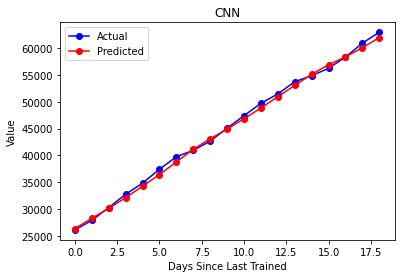

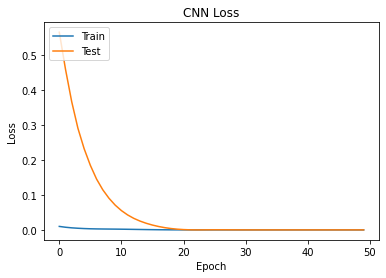

In [47]:
cpreds = scaler.inverse_transform(cnn.predict(X_test))
plot_test('CNN', ys, cpreds)
evaluate_model('CNN', cnnhistory)

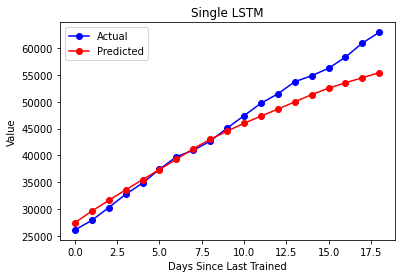

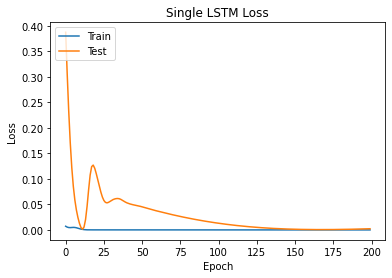

In [42]:
lpreds = scaler.inverse_transform(lstm.predict(X_test))
plot_test('Single LSTM', ys, lpreds)
evaluate_model('Single LSTM', lstmhistory)

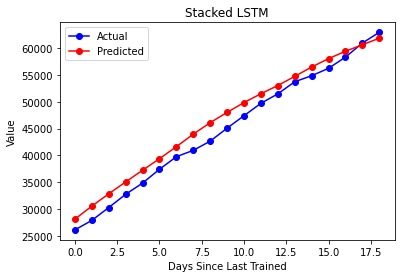

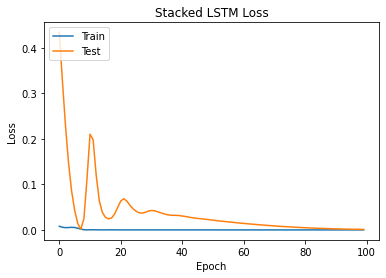

In [41]:
spreds = scaler.inverse_transform(slstm.predict(X_test))
plot_test('Stacked LSTM', ys, spreds)
evaluate_model('Stacked LSTM', slstmhistory)

In [ ]:
# Add YNN Test Here